# Sampling with Delphi

In [2]:
import os
import pickle
import torch
import torch.nn.functional
from model import DelphiConfig, Delphi
from tqdm import tqdm
import pandas as pd
import numpy as np
import textwrap

import matplotlib.pyplot as plt
# %config InlineBackend.figure_format='retina'

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})
plt.rcParams['figure.dpi'] = 72
plt.rcParams['pdf.fonttype'] = 42

#Green
light_male = '#BAEBE3'
normal_male = '#0FB8A1'
dark_male = '#00574A'


#Purple
light_female = '#DEC7FF'
normal_female = '#8520F1'
dark_female = '#7A00BF'


delphi_labels = pd.read_csv('delphi_labels_chapters_colours_icd.csv')
labels = pd.read_csv("data/ukb_simulated_data/labels.csv", header=None, sep="\t")

## Load model

In [3]:
out_dir = 'Delphi-2M'
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype ='float32' #'bfloat16' # 'float32' or 'bfloat16' or 'float16'
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device_type = 'cuda' if 'cuda' in device else 'cpu'
dtype = {'float32': torch.float32, 'float64': torch.float64, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

In [4]:
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)
conf = DelphiConfig(**checkpoint['model_args'])
model = Delphi(conf)
state_dict = checkpoint['model']
model.load_state_dict(state_dict)

model.eval()
model = model.to(device)

number of parameters: 2.24M


In [5]:
checkpoint['model_args']

{'n_layer': 12,
 'n_head': 12,
 'n_embd': 120,
 'block_size': 48,
 'bias': False,
 'vocab_size': 1270,
 'dropout': 0.0,
 'token_dropout': 0.0,
 't_min': 0.1,
 'mask_ties': True,
 'ignore_tokens': [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

## Load data

In [6]:
from utils import get_batch, get_p2i

In [7]:
train = np.fromfile('data/ukb_real_data/train.bin', dtype=np.uint32).reshape(-1,3)
val = np.fromfile('data/ukb_real_data/val.bin', dtype=np.uint32).reshape(-1,3)

train_p2i = get_p2i(train)
val_p2i = get_p2i(val)

## Conditional sampling

### Generating cohorts

In [8]:
d = get_batch(range(0,val_p2i.shape[0]-1,1), val, val_p2i,  
              select='left', block_size=63, 
              device=device, padding='random')

# idx_with_lifestyle_before_60 = torch.where((d[1] <= 60 * 365.25).any(1) * (torch.isin(d[0], torch.tensor([4,5,6,7,8,9,10,11,12], device=device)).any(1)))[0]
# d = get_batch(idx_with_lifestyle_before_60.cpu().numpy(), val, val_p2i, select='left', block_size=80, device=device, padding='random')

In [9]:
age = 60
n_samples = 1024 * 1024

w = np.where((d[1].cpu().detach().numpy() <= age * 365.25).any(1) * (d[3].cpu().detach().numpy() >= age * 365.25).any(1))
# select everything
# w = np.arange(d[0].shape[0])[None]
u = np.unique(w[0])

d0 = d[0][u[:n_samples]].clone().detach()
d1 = d[1][u[:n_samples]].clone().detach()

d0[d1>age*365.25] = 0
d1[d1>age*365.25] = -10000.

if age > 0:
    d0 = torch.nn.functional.pad(d0, (0,1), 'constant', 1)
    d1 = torch.nn.functional.pad(d1, (0,1), 'constant', age*365.25)

o = d1.argsort(1)
d0 = d0.gather(1, o)
d1 = d1.gather(1, o)
d0.shape

torch.Size([63662, 64])

In [10]:
batch_size = 128
n_repeats = 1
oo = []
model.to(device)
for _ in range(n_repeats):
    with torch.no_grad():
        for dd in tqdm(zip(*map(lambda x: torch.split(x, batch_size), (d0,d1))), total=len(d0)//batch_size + 1):
            mm = model.generate(dd[0].to(device), dd[1].to(device), max_age=80*365.25, no_repeat=True, max_new_tokens=128)
            oo += [(mm[0],mm[1])]

  0%|                                                                                                                                                                   | 0/498 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [14:32<00:00,  1.75s/it]


In [11]:
max_len = max(x[1].shape[1] for x in oo)

a = [np.pad(x[0].cpu(), ((0,0), (0, max_len - x[0].shape[1])), constant_values=0) for x in oo]
b = [np.pad(x[1].cpu(), ((0,0), (0, max_len - x[1].shape[1])), constant_values=-10000) for x in oo]


# Concatenate along first dimension
a = np.concatenate(a, axis=0)
print(a.shape)
b = np.concatenate(b, axis=0) / 365.25
b = np.nan_to_num(b, nan=-27).astype('int')

syn_inc = np.zeros((len(labels), 80))
for t in range(80):
    mask = (b == t)
    counts = np.bincount(a[mask], minlength=len(labels))
    syn_inc[:,t] += counts.astype('float')

# syn_inc /= (len(a) - syn_inc[-1].cumsum())
syn_inc /= (len(a) - np.histogram(b.max(1), np.arange(81))[0].cumsum())


(63662, 139)


/ssd/a193o/35377046/cluster_tmp/ipykernel_194387/1636502780.py:20: RuntimeWarning: divide by zero encountered in divide
  syn_inc /= (len(a) - np.histogram(b.max(1), np.arange(81))[0].cumsum())
/ssd/a193o/35377046/cluster_tmp/ipykernel_194387/1636502780.py:20: RuntimeWarning: invalid value encountered in divide
  syn_inc /= (len(a) - np.histogram(b.max(1), np.arange(81))[0].cumsum())


In [12]:
a = d[2][u[:n_samples]].cpu().detach().numpy()#[:,24:]
print(a.shape)
b = np.nan_to_num(d[3].cpu().detach().numpy().copy()[u[:n_samples]] / 365.25, nan=-27).astype('int')#[:,24:]

real_inc = np.zeros((len(labels), 80))
for t in range(80):
    mask = (b == t)
    counts = np.bincount(a[mask], minlength=len(labels))
    real_inc[:,t] = counts.astype('float')
real_inc /= (len(a) - np.histogram(b.max(1) + 1, np.arange(81))[0].cumsum())


(63662, 63)


# Real vs simulated disease rates

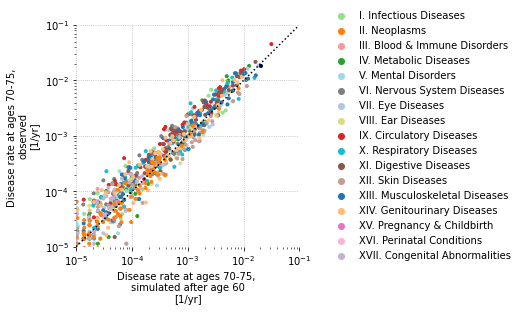

In [13]:
chapter_order = ['Technical', 'Sex', 'Smoking, Alcohol and BMI',
       'I. Infectious Diseases', 'II. Neoplasms', 'III. Blood & Immune Disorders',
       'IV. Metabolic Diseases', 'V. Mental Disorders',
       'VI. Nervous System Diseases', 'VII. Eye Diseases',
       'VIII. Ear Diseases', 'IX. Circulatory Diseases',
       'X. Respiratory Diseases', 'XI. Digestive Diseases',
       'XII. Skin Diseases', 'XIII. Musculoskeletal Diseases',
       'XIV. Genitourinary Diseases', 'XV. Pregnancy & Childbirth',
       'XVI. Perinatal Conditions', 'XVII. Congenital Abnormalities', 'Death']

ages_of_interest = [70, 71, 72, 73, 74]
plt.figure(figsize=(4,4))
plt.scatter(syn_inc[:,ages_of_interest].mean(-1), real_inc[:,ages_of_interest].mean(-1), marker=".", c=delphi_labels['color'])
plt.xlabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nsimulated after age {age}\n[1/yr]')
plt.ylabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nobserved\n[1/yr]')
plt.yscale('log')
plt.xscale('log')
plt.plot([0,1],[0,1], transform=plt.gca().transAxes, c='k', ls=":")
plt.xlim(1e-5,.1)
plt.ylim(1e-5,.1)

for chapter in chapter_order[3:-1]:
    color = delphi_labels[delphi_labels['ICD-10 Chapter (short)'] == chapter]['color'].values[0]
    plt.scatter([], [], c=color, label=chapter)

plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False)
plt.show()

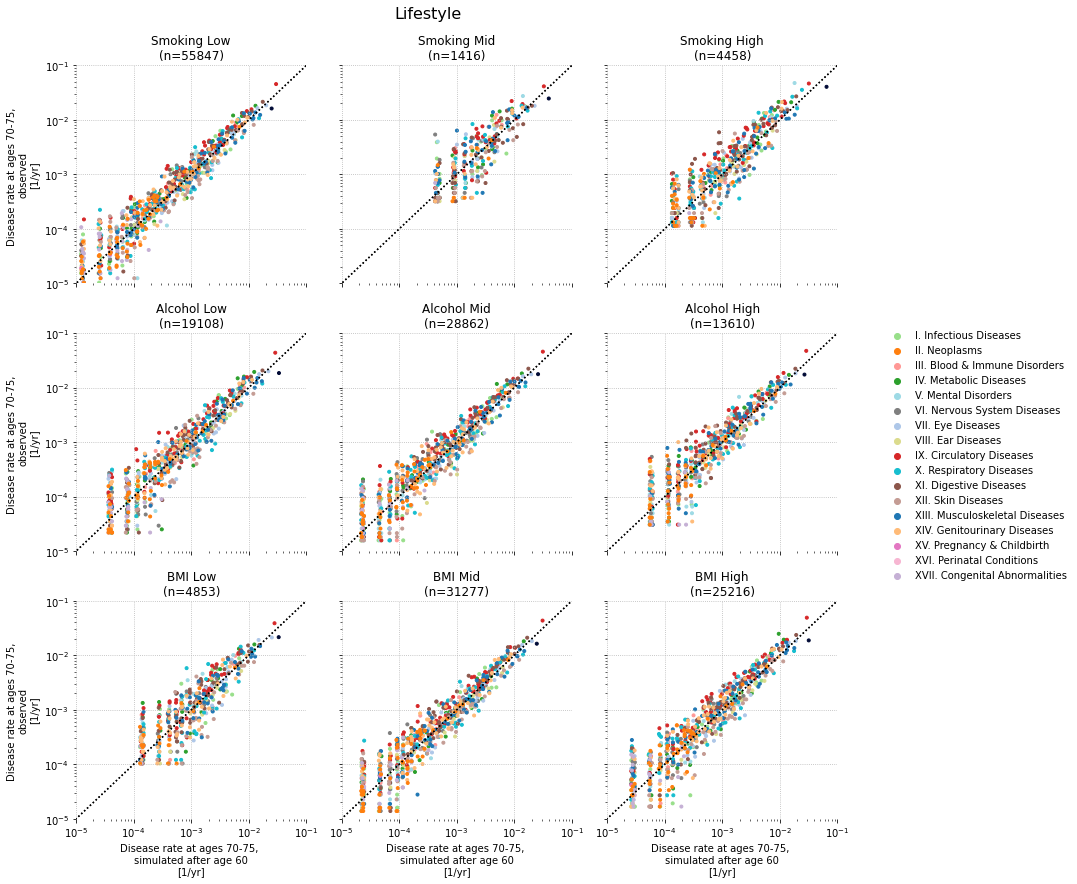

In [14]:
ages_of_interest = [70, 71, 72, 73, 74]

fig, axes = plt.subplots(3, 3, figsize=(12,12), sharex=True, sharey=True)
titles = [['Smoking Low', 'Smoking Mid', 'Smoking High'],
          ['Alcohol Low', 'Alcohol Mid', 'Alcohol High'], 
          ['BMI Low', 'BMI Mid', 'BMI High']]

tokens = [[7, 8, 9],
          [10, 11, 12],
          [4, 5, 6]]

all_syn_inc_lifestyle = np.zeros((9, len(labels)))
all_real_inc_lifestyle = np.zeros((9, len(labels)))

all_syn_inc_lifestyle_token_count = np.zeros((9, len(labels)))
all_real_inc_lifestyle_token_count = np.zeros((9, len(labels)))

all_syn_inc_lifestyle_count_all = np.zeros(9)
all_real_inc_lifestyle_count_all = np.zeros(9)

for i in range(3):
    for j in range(3):

        token_of_interest = tokens[i][j]

        # Get max length for padding
        max_len = max(x[1].shape[1] for x in oo)
        
        # Pad each array with nans and collect
        a = [np.pad(x[0].cpu(), ((0,0), (0, max_len - x[0].shape[1])), constant_values=0) for x in oo]
        b = [np.pad(x[1].cpu(), ((0,0), (0, max_len - x[1].shape[1])), constant_values=-10000) for x in oo]
        
        # Concatenate along first dimension
        a = np.concatenate(a, axis=0)
        b = np.concatenate(b, axis=0) / 365.25
        b = np.nan_to_num(b, nan=-27).astype('int')

        mask_syn = (a==token_of_interest).any(1)
        a = a[mask_syn]
        b = b[mask_syn]

        syn_inc = np.zeros((len(labels), 80))
        for t in range(80):
            mask = (b == t)
            counts = np.bincount(a[mask], minlength=len(labels))
            syn_inc[:,t] += counts.astype('float')

        mask_real = (d[0][u[:n_samples]]==token_of_interest).any(1).cpu().numpy()

        a = d[2][u[:n_samples]][mask_real].cpu().detach().numpy()#[:,24:]
        b = np.nan_to_num(d[3].cpu().detach().numpy().copy()[u[:n_samples]][mask_real] / 365.25, nan=-27).astype('int')#[:,24:]

        real_inc = np.zeros((len(labels), 80))
        for t in range(80):
            mask = (b == t)
            counts = np.bincount(a[mask], minlength=len(labels))
            real_inc[:,t] = counts.astype('float')

        
        all_real_inc_lifestyle_token_count[3*i+j] = real_inc[:,ages_of_interest].sum(-1)
        all_syn_inc_lifestyle_token_count[3*i+j] = syn_inc[:,ages_of_interest].sum(-1)

        all_syn_inc_lifestyle_count_all[3*i+j] = (mask_syn.sum() - syn_inc[-1].cumsum())[ages_of_interest].sum(-1)
        all_real_inc_lifestyle_count_all[3*i+j] = (mask_real.sum() - np.histogram(b.max(1) + 1, np.arange(81))[0].cumsum())[ages_of_interest].sum(-1)

        real_inc /= (mask_real.sum() - np.histogram(b.max(1) + 1, np.arange(81))[0].cumsum())
        syn_inc /= (mask_syn.sum() - syn_inc[-1].cumsum())

        all_syn_inc_lifestyle[3*i+j] = syn_inc[:,ages_of_interest].mean(-1)
        all_real_inc_lifestyle[3*i+j] = real_inc[:,ages_of_interest].mean(-1)

        ax = axes[i,j]

        ax.scatter(syn_inc[:,ages_of_interest].mean(-1), real_inc[:,ages_of_interest].mean(-1), marker=".", c=delphi_labels['color'])
        # ax.scatter(syn_inc[diseases_of_interest,age_of_interest], real_inc[diseases_of_interest,age_of_interest], marker=".", c=delphi_labels['color'].values[diseases_of_interest], edgecolors='k', zorder=10)

        ax.set_xlabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nsimulated after age {age}\n[1/yr]')
        ax.set_ylabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nobserved\n[1/yr]')
        ax.set_yscale('log')
        ax.set_xscale('log') 
        ax.plot([0,1],[0,1], c='k', ls=":")
        ax.plot([0, 10000], [0, 10000], c='k', ls=":")
        ax.set_xlim(1e-5,.1)
        ax.set_ylim(1e-5,.1)
        ax.set_title(titles[i][j] + f'\n(n={mask_real.sum()})')
        ax.label_outer()


# Add legend to the right of the entire figure
for chapter in chapter_order[3:-1]:
    color = delphi_labels[delphi_labels['ICD-10 Chapter (short)'] == chapter]['color'].values[0]
    axes[0,0].scatter([], [], c=color, label=chapter)

fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
plt.suptitle('Lifestyle', y=1.02, size=16)
plt.show()

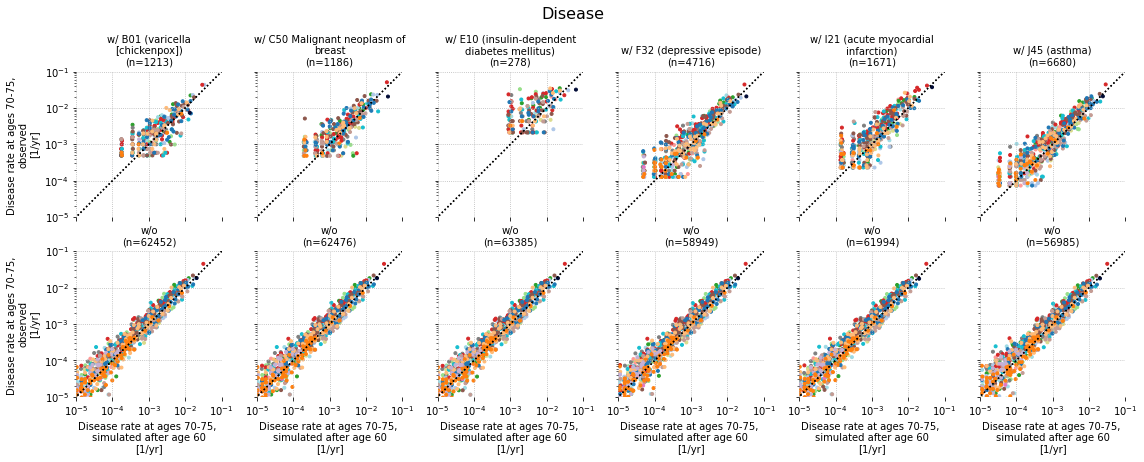

In [15]:
ages_of_interest = [70,71,72,73,74]

tokens = [95, 1188, 214, 305, 505, 603]
diseases_of_interest = [46, 95, 1168, 1188, 374, 214, 305, 505, 603, 1269]

fig, axes = plt.subplots(2, len(tokens), figsize=(16,6), sharex=True, sharey=True)

all_syn_inc_diseases = np.zeros((2 * len(diseases_of_interest), len(labels)))
all_real_inc_diseases = np.zeros((2 * len(diseases_of_interest), len(labels)))

all_syn_inc_diseases_token_count = np.zeros((2 * len(diseases_of_interest), len(labels)))
all_real_inc_diseases_token_count = np.zeros((2 * len(diseases_of_interest), len(labels)))

all_syn_inc_diseases_count_all = np.zeros(2 * len(diseases_of_interest))
all_real_inc_diseases_count_all = np.zeros(2 * len(diseases_of_interest))


for j in range(2):
    for i in range(len(tokens)):
        token_of_interest = tokens[i]
        title = f'{["w/", "w/o"][j]} {labels.iloc[token_of_interest].values[0]}'

        # Get max length for padding
        max_len = max(x[1].shape[1] for x in oo)
        
        # Pad each array with nans and collect
        a = [np.pad(x[0].cpu(), ((0,0), (0, max_len - x[0].shape[1])), constant_values=0) for x in oo]
        b = [np.pad(x[1].cpu(), ((0,0), (0, max_len - x[1].shape[1])), constant_values=-10000) for x in oo]
        
        # Concatenate along first dimension
        a = np.concatenate(a, axis=0)
        b = np.concatenate(b, axis=0) / 365.25
        b = np.nan_to_num(b, nan=-27).astype('int')

        if j == 0:
            mask_syn = ((a==token_of_interest) * (b < 60)).any(1)
        else:
            mask_syn = ~((a==token_of_interest) * (b < 60)).any(1)

        a = a[mask_syn]
        b = b[mask_syn]

        syn_inc = np.zeros((len(labels), 80))
        for t in range(80):
            mask = (b == t)
            counts = np.bincount(a[mask], minlength=len(labels))
            syn_inc[:,t] = counts.astype('float')


        a = d[2][u[:n_samples]].cpu().detach().numpy()#[:,24:]
        b = np.nan_to_num(d[3].cpu().detach().numpy().copy()[u[:n_samples]] / 365.25, nan=-27).astype('int')#[:,24:]

        if j == 0:
            mask_real = ((a==token_of_interest) * (b < 60)).any(1)
        else:
            mask_real = ~((a==token_of_interest) * (b < 60)).any(1)

        a = a[mask_real]
        b = b[mask_real]

        real_inc = np.zeros((len(labels), 80))
        for t in range(80):
            mask = (b == t)
            counts = np.bincount(a[mask], minlength=len(labels))
            real_inc[:,t] = counts.astype('float') 
        all_real_inc_diseases_token_count[j*len(tokens)+i] = real_inc[:,ages_of_interest].sum(-1)
        all_syn_inc_diseases_token_count[j*len(tokens)+i] = syn_inc[:,ages_of_interest].sum(-1)

        all_syn_inc_diseases_count_all[j*len(tokens)+i] = (mask_syn.sum() - syn_inc[-1].cumsum())[ages_of_interest].sum()
        all_real_inc_diseases_count_all[j*len(tokens)+i] = (mask_real.sum() - np.histogram(b.max(1) + 1, np.arange(81))[0].cumsum())[ages_of_interest].sum()

        real_inc /= (mask_real.sum() - np.histogram(b.max(1) + 1, np.arange(81))[0].cumsum())
        syn_inc /= (mask_syn.sum() - syn_inc[-1].cumsum())  

        all_syn_inc_diseases[j*len(tokens)+i] = syn_inc[:,ages_of_interest].mean(-1)
        all_real_inc_diseases[j*len(tokens)+i] = real_inc[:,ages_of_interest].mean(-1)

        ax = axes[j][i]
        ax.scatter(syn_inc[:,ages_of_interest].mean(-1), real_inc[:,ages_of_interest].mean(-1), marker=".", c=delphi_labels['color'])

        ax.set_xlabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nsimulated after age {age}\n[1/yr]')
        ax.set_ylabel(f'Disease rate at ages {ages_of_interest[0]}-{ages_of_interest[-1]+1}, \nobserved\n[1/yr]')
        ax.set_yscale('log')
        ax.set_xscale('log') 
        ax.plot([0,1],[0,1], c='k', ls=":")
        ax.plot([0, 10000], [0, 10000], c='k', ls=":")
        ax.set_xlim(1e-5,.1)
        ax.set_ylim(1e-5,.1)
        ax.set_xticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
        if j == 0:
            ax.set_title(textwrap.fill(title, 30) + f'\n(n={mask_syn.sum()})', fontsize=10)
        else:
            ax.set_title('w/o' + f'\n(n={mask_real.sum()})', fontsize=10)
        
        ax.label_outer()
        ax.set_aspect('equal')


# Add legend to the right of the entire figure
for chapter in chapter_order[3:-1]:
    color = delphi_labels[delphi_labels['ICD-10 Chapter (short)'] == chapter]['color'].values[0]
    axes[0][0].scatter([], [], c=color, label=chapter)

# fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
plt.suptitle('Disease', y=1.05, size=16)
plt.show()

## Real vs simulated disease rate fold change between subcohorts


In [16]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))


def plot_fold_change_comparison(fold_change_syn, fold_change_real, fold_change_syn_sd, fold_change_real_sd, 
                              labels, delphi_labels, title_prefix, xlabel_prefix, n_plots=4, figsize=(14,3), corr_mask=None):
    """Plot comparison of fold changes between synthetic and real data.
    
    Args:
        fold_change_syn: List of synthetic fold changes for each comparison
        fold_change_real: List of real fold changes for each comparison  
        fold_change_syn_sd: List of synthetic fold change standard deviations
        fold_change_real_sd: List of real fold change standard deviations
        labels: List of labels for each comparison plot
        delphi_labels: DataFrame with color and count info for points
        title_prefix: String prefix for plot titles
        xlabel_prefix: String prefix for x-axis labels
        n_plots: Number of comparison plots to create
    """
    fig, axes = plt.subplots(1, n_plots, figsize=figsize, sharex=True, sharey=True)

    for i in range(n_plots):
        non_nan = ~np.isnan(fold_change_syn[i]) * ~np.isnan(fold_change_real[i]) * ~np.isinf(fold_change_syn[i]) * \
            ~np.isinf(fold_change_real[i]) * (fold_change_syn[i] > 0) * (fold_change_real[i] > 0) * (np.arange(len(fold_change_real[i])) > 13)
        
        corr_weights = (1/fold_change_syn_sd[i])**2
        corr_weights = corr_weights / corr_weights[non_nan].sum()
        r_weighted = corr(np.log10(fold_change_syn[i][non_nan]), np.log10(fold_change_real[i][non_nan]), corr_weights[non_nan])
        r = np.corrcoef(np.log10(fold_change_syn[i][non_nan]), np.log10(fold_change_real[i][non_nan]))[0,1]

        ax = axes[i]
        for j in range(len(fold_change_syn[i])):
            if non_nan[j]:
                xerr = fold_change_syn[i][j] - np.exp(np.log(fold_change_syn[i][j]) + np.array([-1,1]) * 2 * fold_change_syn_sd[i][j])
                yerr = fold_change_real[i][j] - np.exp(np.log(fold_change_real[i][j]) + np.array([-1,1]) * 2 * fold_change_real_sd[i][j])
                # ax.errorbar(fold_change_syn[i][j], fold_change_real[i][j],
                #         xerr=np.abs(xerr)[:, None], yerr=np.abs(yerr)[:, None],
                #         fmt='none', c=(0.8, 0.8, 0.8), lw=0.5, alpha=1, zorder=-3)
        sizes = delphi_labels['count'].values[non_nan] / 250
        ax.scatter(fold_change_syn[i][non_nan], fold_change_real[i][non_nan],
                   marker=".", c=delphi_labels['color'][non_nan], s=sizes)
    
        
        # plot median
        # ax.scatter(np.median(fold_change_syn[i][non_nan]), np.median(fold_change_real[i][non_nan]), marker="x", c='k', zorder=10)

        ax.set_title(f'{labels[i]}, \nr={r:.2f},\nr_weighted={r_weighted:.2f}', fontsize=10)
        ax.set_xlabel(f'Fold change in modelled rate, {labels[i]}')
        # ax.set_ylabel(f'Fold change in observed rate, {labels[i]}')
        ax.set_xlabel(f'Fold change, modelled')
        if i == 0:
            ax.set_ylabel(f'Fold change, observed')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.plot([0.1,30],[0.1,30], c='k', ls=":")
        ax.set_xlim(0.1,30)
        ax.set_ylim(0.1,30)
        ax.set_aspect('equal')

    # add legend to the righttmost plot
    legend_sizes = [100, 1000, 10000]
    legend_elements = [plt.scatter([], [], c='gray', s=size/250, label=f'n={size}') 
                            for size in legend_sizes]
    ax.legend(handles=legend_elements, title='Sample size', 
                    loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

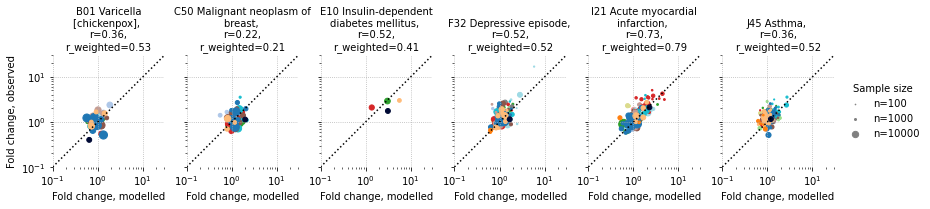

In [17]:

# Compare disease vs no disease fold changes for all 10 diseases
fold_change_real_disease = []
fold_change_syn_disease = []
fold_change_real_disease_sd = []
fold_change_syn_disease_sd = []
disease_comparisons = []


# Calculate fold changes for each disease vs no disease
for i in range(6):  # 10 diseases
    with np.errstate(divide='ignore', invalid='ignore'):
        fold_change_real_disease.append(all_real_inc_diseases[i] / all_real_inc_diseases[i+6])
        fold_change_syn_disease.append(all_syn_inc_diseases[i] / all_syn_inc_diseases[i+6])

        fold_change_real_disease[i][all_real_inc_diseases_token_count[i] < 10] = np.nan
        fold_change_syn_disease[i][all_syn_inc_diseases_token_count[i] < 10] = np.nan

        # Calculate standard deviations
        fold_change_real_disease_sd.append(
            np.sqrt(1/all_real_inc_diseases_token_count[i] + 1/all_real_inc_diseases_count_all[i] + 
                    1/all_real_inc_diseases_token_count[i+6] + 1/all_real_inc_diseases_count_all[i+6])
        )

        fold_change_syn_disease_sd.append(
            np.sqrt(1/all_syn_inc_diseases_token_count[i] + 1/all_syn_inc_diseases_count_all[i] + 
                    1/all_syn_inc_diseases_token_count[i+6] + 1/all_syn_inc_diseases_count_all[i+6])
        )
        
        disease_comparisons.append(textwrap.fill(delphi_labels.iloc[[95, 1188, 214, 305, 505, 603][i]]['name'], 25))

# Create comparison plots
plot_fold_change_comparison(
    fold_change_syn=fold_change_syn_disease,
    fold_change_real=fold_change_real_disease,
    fold_change_syn_sd=fold_change_syn_disease_sd,
    fold_change_real_sd=fold_change_real_disease_sd,
    labels=disease_comparisons,
    delphi_labels=delphi_labels,
    title_prefix='Disease',
    xlabel_prefix='Disease', 
    n_plots=6,
    figsize=(14,4)
)

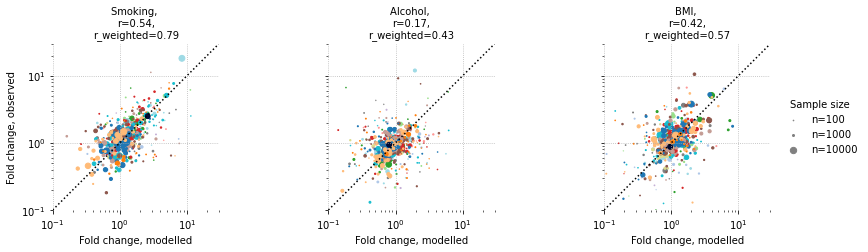

In [18]:
with np.errstate(divide='ignore', invalid='ignore'):
    fold_change_real_lifestyle = [all_real_inc_lifestyle[2] / all_real_inc_lifestyle[0], all_real_inc_lifestyle[5] / all_real_inc_lifestyle[3], all_real_inc_lifestyle[8] / all_real_inc_lifestyle[6]]
    fold_change_syn_lifestyle = [all_syn_inc_lifestyle[2] / all_syn_inc_lifestyle[0], all_syn_inc_lifestyle[5] / all_syn_inc_lifestyle[3], all_syn_inc_lifestyle[8] / all_syn_inc_lifestyle[6]]

    fold_change_real_lifestyle_sd = [
        np.sqrt(1/all_real_inc_lifestyle_token_count[2] + 1/all_real_inc_lifestyle_count_all[2] + 1/all_real_inc_lifestyle_token_count[0] + 1/all_real_inc_lifestyle_count_all[0]),
        np.sqrt(1/all_real_inc_lifestyle_token_count[5] + 1/all_real_inc_lifestyle_count_all[5] + 1/all_real_inc_lifestyle_token_count[3] + 1/all_real_inc_lifestyle_count_all[3]),
        np.sqrt(1/all_real_inc_lifestyle_token_count[8] + 1/all_real_inc_lifestyle_count_all[8] + 1/all_real_inc_lifestyle_token_count[6] + 1/all_real_inc_lifestyle_count_all[6])
    ]

    fold_change_syn_lifestyle_sd = [
        np.sqrt(1/all_syn_inc_lifestyle_token_count[2] + 1/all_syn_inc_lifestyle_count_all[2] + 1/all_syn_inc_lifestyle_token_count[0] + 1/all_syn_inc_lifestyle_count_all[0]),
        np.sqrt(1/all_syn_inc_lifestyle_token_count[5] + 1/all_syn_inc_lifestyle_count_all[5] + 1/all_syn_inc_lifestyle_token_count[3] + 1/all_syn_inc_lifestyle_count_all[3]),
        np.sqrt(1/all_syn_inc_lifestyle_token_count[8] + 1/all_syn_inc_lifestyle_count_all[8] + 1/all_syn_inc_lifestyle_token_count[6] + 1/all_syn_inc_lifestyle_count_all[6])
    ]

lifestyle = ['Smoking', 'Alcohol', 'BMI']

plot_fold_change_comparison(
    fold_change_syn=fold_change_syn_lifestyle,
    fold_change_real=fold_change_real_lifestyle,
    fold_change_syn_sd=fold_change_syn_lifestyle_sd,
    fold_change_real_sd=fold_change_real_lifestyle_sd,
    labels=lifestyle,
    delphi_labels=delphi_labels,
    title_prefix='Lifestyle',
    xlabel_prefix='Lifestyle',
    n_plots=3
)


## Real vs simulated disease rate time to next token

Text(0, 0.5, 'Time to next token')

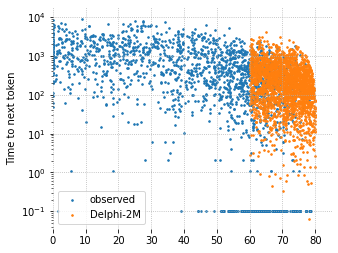

In [19]:
plt.figure(figsize=(5,4))

plt.scatter(d[1][u[:64]].cpu()[:,:-1].flatten()/365.25, .1+np.diff(d[1][u[:64]].cpu().detach(), axis=1).flatten(), marker='.', s=10, label='observed')

plt.scatter(oo[0][1].cpu()[:,64:-1].flatten()/365.25, np.diff(oo[0][1][:,64:].cpu().detach(), axis=1).flatten(), marker='.', s=10, label='Delphi-2M')
plt.yscale('log')
plt.legend()
plt.xlim(0,85)
plt.ylabel('Time to next token')

### Whole validation cohort

In [20]:
from tqdm import tqdm

In [21]:
def aggregate(x, t, start, end):
    t = t.clamp(start, end)
    use = ((t >= start) * (t<end))+0.
    dt = t.diff(1)
    return torch.einsum("ijk,ij->ik", (x.nan_to_num() * use[:,:-1,None]), dt)

In [22]:
d = get_batch(range(0,val_p2i.shape[0]-1,1), val, val_p2i,  
              select='left', block_size=63, 
              device=device, padding='random')

In [23]:
age_sample = 60
n_samples = 1024 * 4

w = np.where((d[1].cpu().detach().numpy() <= age_sample * 365.25) * (d[3].cpu().detach().numpy() >= age_sample * 365.25))
u = np.unique(w[0])
n_samples = len(u)

d0 = d[0][u[:n_samples]].clone().detach()
d1 = d[1][u[:n_samples]].clone().detach()

d0[d1>age_sample*365.25] = 0
d1[d1>age_sample*365.25] = -10000.

if age_sample > 0:
    d0 = torch.nn.functional.pad(d0, (0,1), 'constant', 1)
    d1 = torch.nn.functional.pad(d1, (0,1), 'constant', age_sample*365.25)

o = d1.argsort(1)
d0 = d0.gather(1, o)
d1 = d1.gather(1, o)

In [24]:
batch_size = 128
ooo = []
iinc = []
model.to(device)

with torch.no_grad():
    for rep in range(1):
        oo = []
        inc = []
        for dd in tqdm(zip(*map(lambda x: torch.split(x, batch_size), (d0,d1))), total=n_samples//batch_size + 1):
            mm = model.generate(dd[0].to(device), dd[1].to(device), max_age=80*365.25, no_repeat=True)
            oo += [(mm[0].cpu(),mm[1].cpu())]
            inc += [torch.stack([aggregate(mm[2][:,:-1].exp(), mm[1].nan_to_num(80 * 365.25), a * 365.25, (a+1)* 365.25)/\
                                 aggregate(~mm[2][:,:-1].isnan(), mm[1].nan_to_num(80 * 365.25), a * 365.25, (a+1)* 365.25) for a in range(40, 80)], dim=2).cpu()]
        ooo += [oo]
        iinc += [inc]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [15:25<00:00,  1.86s/it]


In [25]:
inc = torch.stack([torch.vstack([i for i in inc]) for inc in iinc])[0].transpose(1,2) #.median(0).values
inc *= 365.25
n_samples = inc.shape[0]

In [26]:
def comp_at_risk(idx, age, size=1270):
    fill = idx + 0
    fill[fill == 1] = 0
    logits = torch.ones((idx.shape[0], idx.shape[1], size))
    logits = torch.stack([logits[:,j].scatter_(1, fill[:,:j+1], 0.0) for j in range(fill.shape[1])]).transpose(0,1)
    return logits

In [27]:
def agg_inc(d0, d1, pad=2.5, normalize="lof"):
    k = d0
    j = (d1/365.25).nan_to_num(-27).int()
    inc = torch.histogramdd(torch.stack([j.flatten(), k.flatten()], dim=1).float(), bins=[torch.arange(101).float(), torch.arange(1271).float()]).hist
    N = inc.sum(1)
    if normalize=="lof":
        inc /= (d0.shape[0] - torch.histogram((d1/365.25).max(1).values+pad, bins=torch.arange(0,101).float()).hist.cumsum(0)[:,None])
    elif normalize=="death":
        inc /= (d0.shape[0] - inc[:,-1].cumsum(0)[:,None])
    return inc, N

In [28]:
inc_sim = torch.stack([agg_inc(*x, normalize=False)[0] for x in oo]).sum(0)
inc_sim /= (n_samples - inc_sim[:,-1].cumsum(0)[:,None])

In [29]:
d_obs = (d[2][u[:n_samples]].cpu(),d[3][u[:n_samples]].cpu())
l_max = max([x[0].shape[1] for x in ooo[0]])

d_sim = (torch.vstack([torch.zeros([x[0].shape[0], l_max]).slice_scatter(x[0], dim=1, start=l_max-x[0].shape[1]).int() for x in ooo[0]]),
         torch.vstack([torch.zeros([x[1].shape[0], l_max]).slice_scatter(x[1], dim=1, start=l_max-x[1].shape[1]) for x in ooo[0]]))

N = agg_inc(*d_sim)[1]

In [30]:
inc_obs = agg_inc(*d_obs, pad=3.)[0]
inc_sim = agg_inc(*d_sim, normalize='death')[0]
#inc_obs /= (n_samples - torch.histogram((d_obs[1]/365.25).max(1).values+2.5, bins=torch.arange(0,101).float()).hist.cumsum(0)[:,None])

In [31]:
diseases_of_interest = [np.where(labels[0].str.startswith(x))[0][0] for x in ['A41','B01','C25','C50','G30','E11','F32','I21','J45','Death',]] #M19

In [32]:
d_ = d0.cpu()
t_sim =  [set(np.where(inc[i,-1].isnan())[0]) - set(d_[i].cpu().numpy())  for i in range(inc.shape[0])]

In [33]:
n_sim = inc[:,10:,13:].isnan().sum(-1)
#n_sim = np.array([len(x) for x in t_sim])

age_sample = 60
n_obsyears = (d_obs[1][:,-1]/365.25).ceil().long().clamp(max=79) - age_sample

n_sim = n_sim.take_along_dim(n_obsyears[:,None], 1).squeeze()
t_obs = [set(d_obs[0][i][(d_obs[1][i] > age_sample*365.25) * (d_obs[1][i] < 80*365.25) * (d_obs[0][i] > 12)].numpy())  for i in range(inc.shape[0])]
n_obs = ((d_obs[1] > age_sample * 365.25) * (d_obs[1] < 80 * 365.25) * (d_obs[0] > 12)).sum(-1)

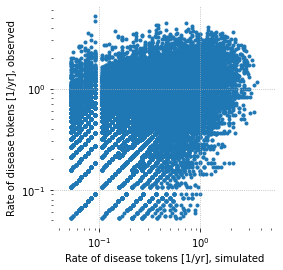

In [34]:
plt.figure(figsize=(4,4))
plt.gca().axis('equal')
plt.scatter((n_sim/n_obsyears)[n_obsyears>10], (n_obs/n_obsyears)[n_obsyears>10], marker=".")
plt.xlabel('Rate of disease tokens [1/yr], simulated')
plt.ylabel('Rate of disease tokens [1/yr], observed')
plt.yscale('log')
plt.xscale('log')

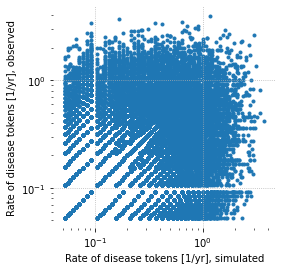

In [35]:
plt.figure(figsize=(4,4))
plt.gca().axis('equal')
plt.scatter((n_sim/n_obsyears)[n_obsyears>10], (n_sim.flip(0)/n_obsyears)[n_obsyears>10], marker=".")
plt.xlabel('Rate of disease tokens [1/yr], simulated')
plt.ylabel('Rate of disease tokens [1/yr], observed')
plt.yscale('log')
plt.xscale('log')

In [36]:
n_sim_obs = np.array([len(t_obs[i] & t_sim[i]) for i in range(inc.shape[0])])

In [37]:
p = np.arange(len(t_sim))
p[np.where((d0[:n_samples].cpu() == 2).any(1))[0]] = p[np.where((d0[:n_samples].cpu() == 2).any(1))[0]][::-1]
p[np.where((d0[:n_samples].cpu() == 3).any(1))[0]] = p[np.where((d0[:n_samples].cpu() == 3).any(1))[0]][::-1]
p[np.where(~(d0[:n_samples].cpu() == 2).any(1) * ~(d0[:n_samples].cpu() == 3).any(1))[0]] = p[np.where(~(d0[:n_samples].cpu() == 2).any(1) * ~(d0[:n_samples].cpu() == 3).any(1))[0]][::-1]

#np.concatenate([np.where((d0.cpu() == 2).any(1))[0][::-1], np.where((d0.cpu() == 3).any(1))[0][::-1]

In [38]:
n_sim_obs_perm = np.array([len(t_obs[i] & t_sim[p[i]]) for i in range(inc.shape[0])])

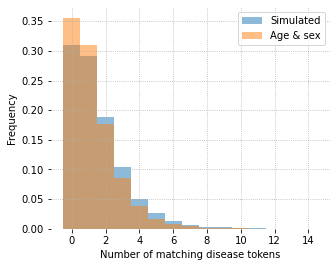

In [39]:
plt.figure(figsize=(5,4))
h0 = plt.hist(n_sim_obs[n_obsyears > 10 ], bins=np.arange(-.5,15), alpha=0.5, label='Simulated', density=True)
h1 = plt.hist(n_sim_obs_perm[n_obsyears > 10], bins=np.arange(-.5,15), alpha=0.5, label='Age & sex', density=True)
plt.xlabel('Number of matching disease tokens')
plt.ylabel('Frequency')
plt.legend()

In [40]:
batch_size = 128
max_iters = float("Inf")
n_rep = 1
lll = []
model.to(device)
ooo = []
with torch.no_grad():
    for i,dd in tqdm(enumerate(zip(*map(lambda x: torch.split(x, batch_size), (d0,d1, d[1][u[:n_samples]].cpu())))), position=0,  total=n_samples//batch_size + 1):
        if i >= max_iters: 
            break
        oo = []
        for rep in range(n_rep):
            idx, age, logits = model.generate(dd[0].to(device), dd[1].to(device), max_age=80*365.25, no_repeat=True)
            oo += [(idx.cpu(),age.cpu())]
        ooo += [oo]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [14:43<00:00,  1.78s/it]


In [41]:
dd_sim = []
for rep in tqdm(range(n_rep)): 
    l_max = max([x[rep][0].shape[1] for x in ooo])
    
    d_sim = (torch.vstack([torch.zeros([x[rep][0].shape[0], l_max]).slice_scatter(x[rep][0], dim=1, start=l_max-x[rep][0].shape[1]).int() for x in ooo]),
             torch.vstack([torch.zeros([x[rep][1].shape[0], l_max]).slice_scatter(x[rep][1], dim=1, start=l_max-x[rep][1].shape[1]) for x in ooo]))
    dd_sim += [d_sim]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.54it/s]


In [42]:
batch_size=128
inc = []
with torch.no_grad():
    for i,dd in tqdm(enumerate(zip(*map(lambda x: torch.split(x, batch_size), (d0,d1)))), position=0,  total=n_samples//batch_size + 1):
        logits, _, _ = model(dd[0].to(device),dd[1].to(device))
        inc += [logits[:,-2:,:].cpu()]
inc = torch.vstack(inc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 498/498 [00:11<00:00, 43.54it/s]


In [43]:
inc = 1-(-inc.exp()*365.25).exp()

In [44]:
n_sim_obs = []
n_sim_obs_perm = []
for d_sim in dd_sim:
    t_sim = [set(d_sim[0][i][(d_sim[1][i] > age_sample*365.25) * (d_sim[1][i] < 80*365.25) * (d_sim[0][i] > 12)].numpy())  for i in range(inc.shape[0])]
    n_sim = ((d_sim[1] > age_sample * 365.25) * (d_sim[1] < 80 * 365.25) * (d_sim[0] > 12)).sum(-1)
    n_sim_obs += [np.array([len(t_obs[i] & t_sim[i]) for i in range(inc.shape[0])])]
    n_sim_obs_perm += [np.array([len(t_obs[i] & t_sim[p[i]]) for i in range(inc.shape[0])])]
n_sim_obs = np.array(n_sim_obs)
n_sim_obs_perm = np.array(n_sim_obs_perm)

/ssd/a193o/35377046/cluster_tmp/ipykernel_194387/3291688939.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot([np.nanmean(n_sim_obs[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Delphi-2M', ds='steps', c='C1')
/ssd/a193o/35377046/cluster_tmp/ipykernel_194387/3291688939.py:3: RuntimeWarning: Mean of empty slice
  plt.plot([np.nanmean(n_sim_obs[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Delphi-2M', ds='steps', c='C1')
/ssd/a193o/35377046/cluster_tmp/ipykernel_194387/3291688939.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot([np.nanmean(n_sim_obs_perm[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Age and sex', ds='steps', c='C0')
/ssd/a193o/35377046/cluster_tmp/ipykernel_194387/3291688939.py:4: RuntimeWarning: Mean of empty slice
  plt.plot([np.nanmean(n_sim_obs_perm[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in ran

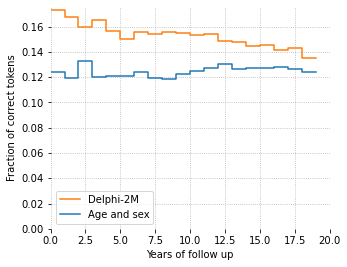

In [45]:
plt.figure(figsize=(5,4))

plt.plot([np.nanmean(n_sim_obs[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Delphi-2M', ds='steps', c='C1')
plt.plot([np.nanmean(n_sim_obs_perm[:,n_obsyears==x].mean(0)/n_obs[n_obsyears==x].numpy())  for x in range(20)], label='Age and sex', ds='steps', c='C0')
plt.xlim(0,20)
plt.xlabel('Years of follow up')
plt.ylabel('Fraction of correct tokens')
plt.ylim(0,None)
plt.legend()

## Delphi stratifies trajectories into low-, mid- and high-risk groups

In [46]:
def get_surv(d, k):
    w = d[0]==k
    x,y = (d[0]==k)[w], d[1][w]
    v = w.int().sum(1)==0
    return  torch.concat([x,torch.zeros(v.sum()).bool()]).numpy(), torch.concat([y, d[1][v,-1]]).numpy()

In [47]:
diseases_of_interest

[46, 95, 1168, 1188, 374, 215, 305, 505, 603, 1269]

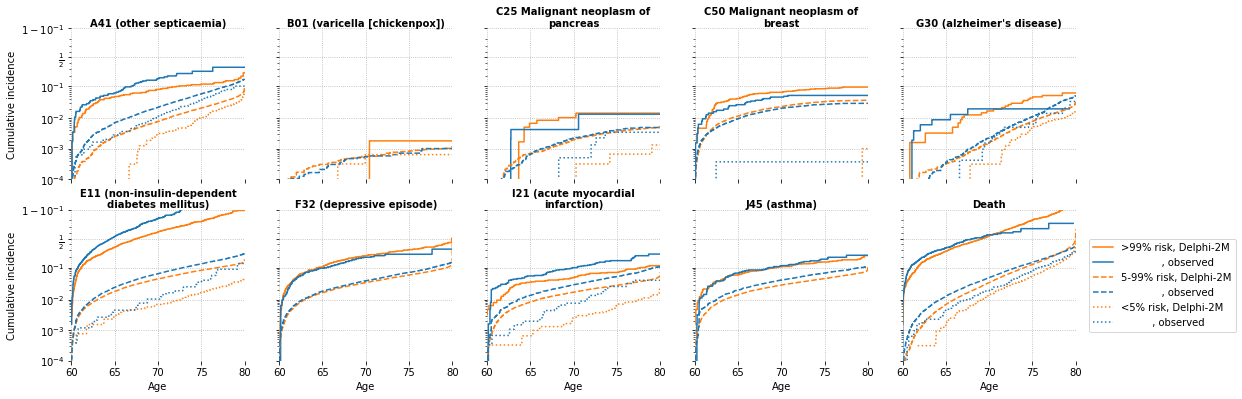

In [48]:
import sksurv
import sksurv.nonparametric
import textwrap

fig, ax = plt.subplots((len(diseases_of_interest)-1)//5+1,5, figsize=(18,(3*(len(diseases_of_interest)-1)//5+1)), sharex=True, sharey=True)
for l,k in enumerate(diseases_of_interest):# 1168# 1269
    axf = ax.ravel()
    for g in range(3):
        if g == 2:
            w = inc[:,-1,k] <= torch.quantile(inc[:,-1,k].nan_to_num(), 0.05)
        elif g == 1:
            w = (inc[:,-1,k] > torch.quantile(inc[:,-1,k].nan_to_num(), 0.05)) * (inc[:,-1,k] <= torch.quantile(inc[:,-1,k].nan_to_num(), 0.99))
        else:
            w = inc[:,-1,k] > torch.quantile(inc[:,-1,k].nan_to_num(), 0.99)
        w *= ~((d_obs[0] == k) * (d_obs[1]/365.25 < 60)).any(1)
        w.sum()

        r = -(1-inc[w,-1,k]).log()/365.25
        c = 1-(-r.mean()*torch.arange(20*365.25)).exp()

        def cuminc(x):
            return x[0], 1-x[1] + 1e-6

        d_sim = torch.vstack([x[0][w][:,:114] for x in dd_sim]), torch.vstack([x[1][w][:,:114].nan_to_num(-10000.)/365.25 for x in dd_sim])
        o = d_sim[1].argsort(1)
        d_sim = d_sim[0].gather(1,o), d_sim[1].gather(1,o)
        
        try:
            axf[l].plot(*cuminc(sksurv.nonparametric.kaplan_meier_estimator(*get_surv(d_sim, k))), label=f'{[">99%","5-99%","<5%"][g]} risk, Delphi-2M',  ls=["-","--",":"][g], c="C1", ds='steps-post') #c=['C3','C7','C0']
        except:
            pass
        
        if (d_obs[0][w]==k).sum() < 1:
            continue
        
        try:
            axf[l].plot(*cuminc(sksurv.nonparametric.kaplan_meier_estimator(*get_surv((d_obs[0][w],d_obs[1][w]/365.25), k))), label=f'{["             ","             ","          "][g]}, observed',  ls=["-","--",":"][g], c="C0" ,ds='steps-post')
        except:
            pass

        #plt.plot(torch.arange(20*365.25)/365.25+60, c, c="C2", ls=[":","--","-"][g])
    axf[l].set_xlim(60,80)
    axf[l].set_ylim(1e-4,0.9)
    axf[l].set_yscale('logit')
    if l % ax.shape[1] ==0:
        axf[l].set_ylabel('Cumulative incidence')

    if l // ax.shape[1] == ax.shape[0] -1:
        axf[l].set_xlabel('Age')

    if l == len(diseases_of_interest)-1:
        axf[l].legend(loc='center left', bbox_to_anchor=(1.05, 0.5))        
    axf[l].set_title("\n".join(textwrap.wrap(labels.iloc[k,0], width=30)), verticalalignment='top', fontsize=10, fontweight='bold')